In [ ]:
# get a file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchview

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import spearmanr
import joblib
import numpy as np
import abc
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as f
import heapq
import random
from tqdm import tqdm

# Metric Learning
## High-level Description
Standard reinforcement learning has many issues: it can be unstable (requiring multiple seeds) and sample inefficient (needing costly environment interactions). To address this, recent methods treat RL as a supervised learning problem—mapping states and desired goals to optimal actions. These outcome-conditional behavioral cloning (OCBC) algorithms achieve strong results on common benchmarks.

In this homework, you will implement two simplified OCBC methods:

1. One predicts the temporal distance between two states.
2. The other uses contrastive learning.

You will compare them using various metrics, test their stitching capabilities, and present your findings in a report.

## Points
You will be able to get 10 points in total for the homework, it will be split as follows:
- Implementing various "metrics" [1pt]:
    - Correlation and distance plots [0.25pt]
    - Heatmaps [0.25pt]
    - Solved Rate [0.5pt]
- Implement the network architecture, based on BRO net [0.5pt]
- Implement contrastive training correctly [2pt]
- Implementing the supervised training correctly [1.5pt]
- Based on the metrics you implemented, describe how well both implemented methods are working. [1pt]
- Compare the supervised and contrastive methods performance, how do they compare in terms of sample efficiency? [1pt]
- Compare the stitching abilities of the supervised and contrastive method. [1pt]
- Report quality [2pt] (multiplied by the sum of the rest and divided by max of the rest)



## Report
Your solution will be graded based both on the code and the report. A solution without a report gets 0 points. Your report should be a pdf file, based on the provided latex template.

## Datasets

You have been given two [dataset](https://drive.google.com/drive/folders/1-YKwZpttn9Of5zR_poT-lO5coMZ0tvmN?usp=sharing). You can access them, if you log into your university gmail account. If you are using Colab, it's best to put them on Google Drive associated with your University Google account (it's also a good idea to save your checkpoints there). A single 20 by 20 maze has been chosen for both of them.

Each dataset consists of two files, file with trajectories and file with lengths of the corresponding trajectories. They are compressed using the `joblib` library.

The normal dataset contains optimal trajectories going from a randomly sampled start point in the maze to a randomly sampled goal state in the maze.

The 'stitching' dataset contains a subset of trajectories, that have the goal and start states within the same quarter of the maze board.


*   The normal dataset:
    * `maze_trajectories.pkl`
    * `maze_lens.pkl`
*   The stitching dataset:
    * `stitching_trajectories.pkl`
    * `stitching_lens.pkl`

In the saved trajectories, the walls are denoted by 1, start state by 2 and goal state by 3. The are ordered from last to first state. In the last state, the position of the goal state and start state is the same.

The implemented `AbsDataset` reads the trajectories and allows for getting a batch of trajectories from them.
You are to implement two classes deriving from `AbsDataset` - `ContrastiveDataset` and `SupervisedDataset`.

### Supervised Dataset
In Supervised Dataset, the method `get_batch` should return a batch of pairs of states from the same trajectory, they should both be sampled uniformly, and the first state should be earlier in trajectory. For each batch element, a label should be returned, the label being the distance between the sampled states.

### Contrastive Dataset
In the Contrastive Dataset, the method `get_batch` should return a batch of pairs of states from the same trajectory. The first element from the pair should be sampled randomly from the trajectory, while the second should be sampled from an exponential distribution, as described [here](https://arxiv.org/pdf/2206.07568). So, if the first element sampled has index $i$, the probability of the second one having index $i + j$ should be proportional to $\gamma^j$.




In [ ]:
traj_path = '/content/drive/MyDrive/HW_2_Trajectories/maze_trajectories.pkl'
len_path =  '/content/drive/MyDrive/HW_2_Trajectories/maze_lens.pkl'

### DO NOT EDIT ###
class AbsDataset(abc.ABC):
    def __init__(self, path, lens_path, n_train_trajectories, gamma=None):
        # super(Dataset).__init__()
        trajs = joblib.load(path)
        lengths = joblib.load(lens_path)
        # Cast types
        if isinstance(trajs, np.ndarray) and trajs.dtype == np.float64:
            trajs = trajs.astype(np.float32)
        if isinstance(lengths, np.ndarray) and lengths.dtype == np.float64:
            lengths = lengths.astype(np.int32)

        self.trajectories = torch.from_numpy(trajs)
        self.lens = torch.from_numpy(lengths)

        #self.trajectories = torch.from_numpy(joblib.load(path))
        #self.lens = torch.from_numpy(joblib.load(lens_path))

        # Only take the non-empty trajectories from the files
        mask = self.lens == 0
        assert (torch.logical_or(self.trajectories ==2, self.trajectories==2)).sum() == sum(self.lens - 1), f'{(torch.logical_or(self.trajectories ==2, self.trajectories==3)).sum()}, {sum(self.lens)}'
        self.trajectories = self.trajectories[~mask]
        self.lens = self.lens[~mask]
        assert (torch.logical_or(self.trajectories ==2, self.trajectories==2)).sum() == sum(self.lens - 1), f'{(torch.logical_or(self.trajectories ==2, self.trajectories==3)).sum()}, {sum(self.lens)}'
        permutation = np.random.permutation(len(self.trajectories))


        self.train_trajectories = self.trajectories[permutation][:n_train_trajectories]
        self.train_lens = self.lens[permutation][:n_train_trajectories]
        assert (torch.logical_or(self.train_trajectories ==2, self.train_trajectories==2)).sum() == sum(self.train_lens - 1), f'{(torch.logical_or(self.train_trajectories ==2, self.train_trajectories==3)).sum()}, {sum(self.lens)}'

        self.test_trajectories = self.trajectories[permutation][n_train_trajectories:]
        self.test_lens = self.lens[permutation][n_train_trajectories:]

        assert (self.test_trajectories==2).sum() == sum(self.test_lens - 1)

        self.ind = 0
        self.gamma = gamma
        self.max_horizon = 400
        self.device = "cuda" if torch.cuda.is_available() else "cpu"


    def _get_trajs(self, n_traj, split):
        if split not in ['train', 'test']:
            raise ValueError()

        if split == 'train':
            trajectories = self.train_trajectories
            lens = self.train_lens
        else:
            trajectories = self.test_trajectories
            lens = self.test_lens

        if n_traj > len(trajectories):
            n_traj = len(trajectories)

        if self.ind + n_traj > len(trajectories):
            split_1 = trajectories[self.ind:]
            split_2 = trajectories[:self.ind + n_traj - len(trajectories)]
            current_trajectories = torch.concatenate([split_1, split_2], axis=0)

            split_1 = lens[self.ind:]
            split_2 = lens[:self.ind + n_traj - len(trajectories)]
            current_lens = torch.concatenate([split_1, split_2], axis=0)
            permutation = np.random.permutation(len(trajectories))

            if split == 'train':
                self.train_trajectories = self.train_trajectories[permutation]
                self.train_lens = self.train_lens[permutation]
            else:
                self.test_trajectories = self.test_trajectories[permutation]
                self.test_lens = self.test_lens[permutation]



            self.ind = 0

        else:
          current_trajectories = trajectories[self.ind:self.ind + n_traj]
          current_lens = lens[self.ind:self.ind + n_traj]



        # The generated maze trajectories have states of a form where 2 is the start and 3 is the end
        # The first element of each trajectory is the solved state
        # Here we replace all 3 with 2
        # Since this causes the training to be easier, as we only calculate the distance between
        # Two fields with value 2, not taking into account where the goal is
        mask1 = torch.zeros_like(current_trajectories).to(self.device)
        mask1[torch.arange(len(current_trajectories)), 0] = 1
        mask2 = (current_trajectories == 3).to(self.device)
        mask3 = current_lens < len(current_trajectories[0])
        mask3 = mask3.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, len(current_trajectories[0]), 1, 1).to(self.device)

        mask = mask1 * mask2 * mask3

        current_trajectories[mask.to(bool)] = 2
        current_trajectories[current_trajectories == 3] = 0

        assert (current_trajectories == 3).sum() == 0
        assert ((current_trajectories == 2).sum(dim=(1, 2, 3)) == current_lens).all(), f'{(current_trajectories[0] == 2).sum()} {current_lens[0]}'
        assert ((current_trajectories == 2).sum(axis = (2, 3)) <= 1).all()

        self.ind += n_traj
        self.ind %= len(self.trajectories)


        return current_trajectories, current_lens

    @abc.abstractmethod
    def get_batch(self, batch_size):
        pass

    def get_trajectory(self):
        traj, len = self._get_trajs(1)
        traj = traj.squeeze()
        traj = traj.flatten(1)
        len = len.item()

        traj = traj[:len]

        return traj.to(self.device).to(torch.float32)
### DO NOT EDIT ###

class ContrastiveDataset(AbsDataset):
    def get_batch(self, batch_size, split):
        ### TODO ###
        # Sample trajectories and lengths
        trajectories, lengths = self._get_trajs(batch_size, split)
        psi_0_list = []
        psi_T_list = []
        for traj, length in zip(trajectories, lengths):
            l = length.item()
            if l <= 1:
                i = 0
                j = 0
            else:
                # First index uniformly in [0, l-2]
                i = torch.randint(0, l-1, (1,)).item()
                # Sample delta from geometric distribution
                if self.gamma is not None:
                    delta = np.random.geometric(1 - self.gamma)
                    j = i + delta
                    if j >= l:
                        j = l - 1
                else:
                    j = l - 1
            # Flatten the selected states
            s0 = traj[i].flatten()
            s1 = traj[j].flatten()
            psi_0_list.append(s0)
            psi_T_list.append(s1)
        psi_0 = torch.stack(psi_0_list).to(torch.float32).to(self.device)
        psi_T = torch.stack(psi_T_list).to(torch.float32).to(self.device)
        return psi_0, psi_T
        ### TODO ###

class SupervisedDataset(AbsDataset):
    def get_batch(self, batch_size, split):
        ### TODO ###
        # Sample trajectories and lengths
        trajectories, lengths = self._get_trajs(batch_size, split)
        s0_list = []
        s1_list = []
        dist_list = []
        for traj, length in zip(trajectories, lengths):
            l = length.item()
            if l <= 1:
                i = 0
                j = 0
            else:
                # First index uniform, second uniform after first
                i = torch.randint(0, l-1, (1,)).item()
                j = torch.randint(i+1, l, (1,)).item()
            s0 = traj[i].flatten()
            s1 = traj[j].flatten()
            dist = j - i
            s0_list.append(s0)
            s1_list.append(s1)
            dist_list.append(dist)
        s0_batch = torch.stack(s0_list).to(torch.float32).to(self.device)
        s1_batch = torch.stack(s1_list).to(torch.float32).to(self.device)
        dist_batch = torch.tensor(dist_list, dtype=torch.long, device=self.device)
        return s0_batch, s1_batch, dist_batch
        ### TODO ###

class Dataloader():
    def __init__(self, dataset, batch_size, split='train'):
        self.dataset = dataset
        self.batch_size = batch_size
        self.split = split

    def __iter__(self):
        return self

    def __next__(self):
        return self.dataset.get_batch(self.batch_size, split=self.split)

## BRO Net
Implement the architecture based on the [BRO paper](https://arxiv.org/pdf/2405.16158).

In [ ]:
class BroNet(nn.Module):
      ### TODO ####
    def __init__(self, input_size: int = 400, output_size: int = 64):
        super(BroNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.ln1 = nn.LayerNorm(128)

        # Block 1
        self.b1_fc1 = nn.Linear(128, 128)
        self.b1_ln1 = nn.LayerNorm(128)
        self.b1_fc2 = nn.Linear(128, 128)
        self.b1_ln2 = nn.LayerNorm(128)

        # Block 2
        self.b2_fc1 = nn.Linear(128, 128)
        self.b2_ln1 = nn.LayerNorm(128)
        self.b2_fc2 = nn.Linear(128, 128)
        self.b2_ln2 = nn.LayerNorm(128)

        # Block 3
        self.b3_fc1 = nn.Linear(128, 128)
        self.b3_ln1 = nn.LayerNorm(128)
        self.b3_fc2 = nn.Linear(128, 128)
        self.b3_ln2 = nn.LayerNorm(128)

        # Block 4
        self.b4_fc1 = nn.Linear(128, 128)
        self.b4_ln1 = nn.LayerNorm(128)
        self.b4_fc2 = nn.Linear(128, 128)
        self.b4_ln2 = nn.LayerNorm(128)

        self.fc_out = nn.Linear(128, output_size)

    def forward(self, x):
        z1 = self.ln1(self.fc1(x))
        x1 = torch.relu(z1)

        # Block 1
        r1 = self.b1_ln1(self.b1_fc1(x1))
        r1 = torch.relu(r1)
        r1 = self.b1_ln2(self.b1_fc2(r1))
        x2 = x1 + r1

        # Block 2
        r2 = self.b2_ln1(self.b2_fc1(x2))
        r2 = torch.relu(r2)
        r2 = self.b2_ln2(self.b2_fc2(r2))
        x3 = x2 + r2

        # Block 3
        r3 = self.b3_ln1(self.b3_fc1(x3))
        r3 = torch.relu(r3)
        r3 = self.b3_ln2(self.b3_fc2(r3))
        x4 = x3 + r3

        # Block 4
        r4 = self.b4_ln1(self.b4_fc1(x4))
        r4 = torch.relu(r4)
        r4 = self.b4_ln2(self.b4_fc2(r4))
        x5 = x4 + r4

        out = self.fc_out(x5)
        return out
        ### TODO ###

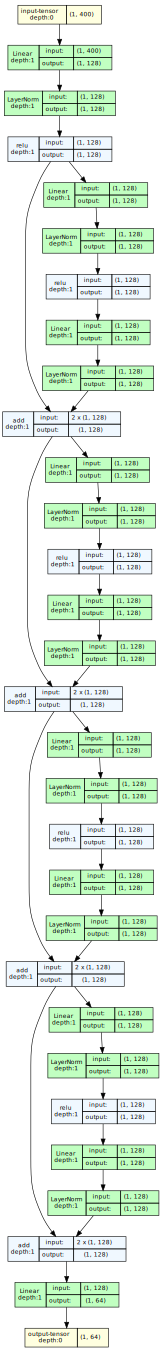

In [ ]:
### DO NOT EDIT ###
from torchview import draw_graph
model = BroNet()
viz = draw_graph(model, input_size=(1, 400), expand_nested=True, device='meta')
viz.visual_graph
### DO NOT EDIT ###

## Contrastive Loss
Implement the symmetrized version of the [InfoNCE](https://arxiv.org/pdf/1807.03748) loss. You don't need to read this paper, but you can scan the intro for some context.

Given two batches of corresponding embeddings $\{z_i\}_{i=1}^N$ and $\{z_i'\}_{i=1}^N$, the **InfoNCE loss** for predicting $z_i'$ from $z_i$ is:

$$
\mathcal{L}_{\text{InfoNCE}}(z_i, z_i') = -\log \frac{\exp(\text{sim}(z_i, z_i') / \tau)}{\sum_{j=1}^{N} \exp(\text{sim}(z_i, z_j') / \tau)}
$$

Where:

* $\text{sim}(a, b) = -||a - b||_2$ is the $\ell_2$ norm,
* $\tau$ is a temperature parameter (a good default value for $\tau$ is the square root of representation dimension),
* The denominator includes the positive and all negatives from the batch.

---

### Symmetrized InfoNCE Loss

To symmetrize, we apply the InfoNCE loss in both directions:

* Predict $z_i'$ from $z_i$
* Predict $z_i$ from $z_i'$

The **Symmetrized InfoNCE** is then:

$$
\mathcal{L}_{\text{Symm-InfoNCE}} = \sum_{i=1}^{N} \left[ \mathcal{L}_{\text{InfoNCE}}(z_i, z_i') + \mathcal{L}_{\text{InfoNCE}}(z_i', z_i) \right]
$$

This encourages mutual information maximization in both directions.

In [ ]:
def contrastive_loss(psi_0, psi_T):
        ### TODO ###
        # Calcualete tau and pairwise similarities.
        N, D = psi_0.shape
        tau = D ** 0.5
        sim_matrix = -torch.cdist(psi_0, psi_T, p=2) / tau

        # InfoNCE loss
        labels = torch.arange(N, device=psi_0.device)
        # loss_1 = InfoNCE loss (z_i, z_i')
        loss_1 = f.cross_entropy(sim_matrix, labels, reduction='sum')

        # loss_2 = InfoNCE loss (z_i', z_i)
        loss_2 = f.cross_entropy(sim_matrix.t(), labels, reduction='sum')

        loss = loss_1 + loss_2
        ### TODO ###
        return loss.mean()

## Training
### Supervised Network Training
The supervised network should receive as input a concatenated pair of state and predict the distance between them. It should be trained with a classification-based objective.

### Contrastive Network Training
The contrastive network should receive as input a single state and return its representation.

In [ ]:
class Trainer(abc.ABC):
    def __init__(self, checkpoint_frequency, output_dir, train_steps, traj_path, model, n_train_trajectories, lr, batch_size):
        self.model = model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)


        self.train_steps = train_steps
        self.output_dir = output_dir
        self.checkpoint_frequency = checkpoint_frequency

        self.lr = lr
        self.batch_size = batch_size
        self.losses = []

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.init_dataset(traj_path, n_train_trajectories)

    @abc.abstractmethod
    def calculate_loss(self, data):
        pass

    @abc.abstractmethod
    def init_dataset(self, traj_path, n_train_trajectories):
        pass

    def train_model(self):
        ### TODO ###
        self.model.train()
        with tqdm(range(self.train_steps), desc="Training", unit="step") as pbar:
            for step in pbar:
                data = self.dataset.get_batch(self.batch_size, split='train')
                loss = self.calculate_loss(data)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.losses.append(loss.item())
                pbar.set_postfix(loss=f"{loss.item():.4f}")

                if (step + 1) % self.checkpoint_frequency == 0:
                    path = os.path.join(self.output_dir, f'checkpoint_step_{step+1}.pth')
                    torch.save(self.model.state_dict(), path)
        ### TODO ###

class ContrastiveTrainer(Trainer):
    def __init__(self, **kwargs):
        self.gamma = kwargs.pop('gamma', 0.99)
        self.len_path = kwargs.pop('len_path', '/content/drive/MyDrive/HW_2_Trajectories/maze_lens.pkl')
        super(ContrastiveTrainer, self).__init__(**kwargs)

    ### TODO ###
    def init_dataset(self, traj_path, n_train_trajectories):
        self.dataset = ContrastiveDataset(traj_path, self.len_path, n_train_trajectories, self.gamma)

    def calculate_loss(self, data):
        psi_0, psi_T = data
        z0 = self.model(psi_0)
        zT = self.model(psi_T)
        return contrastive_loss(z0, zT)
    ### TODO ###

class SupervisedTrainer(Trainer):
    def __init__(self, **kwargs):
        self.len_path = kwargs.pop('len_path', '/content/drive/MyDrive/HW_2_Trajectories/maze_lens.pkl')
        super(SupervisedTrainer, self).__init__(**kwargs)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    ### TODO ###
    def init_dataset(self, traj_path, n_train_trajectories):
        self.dataset = SupervisedDataset(traj_path, self.len_path, n_train_trajectories)

    def calculate_loss(self, data):
        s0, s1, dist = data
        # Concatenate two states into one input vector
        inp = torch.cat([s0, s1], dim=1)
        logits = self.model(inp)
        return self.loss_fn(logits, dist)
    ### TODO ###



## Value Estimators
The goal of this class is to create an abstraction for predicting distance between the two state. Implement one for supervised network and one for the contrastive network.

In [ ]:
class ValueEstimator(abc.ABC):
    def __init__(self, model):
        self.model = model

    def get_solved_distance(self, state_str: np.array, goal: np.array):
        return self.get_solved_distance_batch(np.expand_dims(state_str, 0), np.expand_dims(goal, 0))

    @abc.abstractmethod
    def calculate_distance(self, num_state, num_goal):
        pass

    def get_solved_distance_batch(self, state_str: np.array, goal: np.array):
        assert (state_str == 2).sum() == len(state_str)
        assert (state_str == 3).sum() == 0

        assert (goal == 2).sum() == len(state_str)
        assert (goal == 3).sum() == 0

        num_state = torch.tensor(state_str)
        num_goal = torch.tensor(goal)
        self.model.eval()

        return self.calculate_distance(num_goal, num_state)

class ValueEstimatorContrastive(ValueEstimator):
    def calculate_distance(self, num_state, num_goal):
        ### TODO ###
        device = next(self.model.parameters()).device

        num_state = num_state.to(device).float()
        num_goal = num_goal.to(device).float()

        with torch.no_grad():
            z_state = self.model(num_state)
            z_goal = self.model(num_goal)
        return torch.norm(z_state - z_goal, dim=1)
        ### TODO ###


class ValueEstimatorSupervised(ValueEstimator):
    def calculate_distance(self, num_state, num_goal):
        ### TODO ###
        device = next(self.model.parameters()).device

        num_state = num_state.to(device).float()
        num_goal = num_goal.to(device).float()

        inp = torch.cat([num_state, num_goal], dim=1)

        with torch.no_grad():
            logits = self.model(inp)

        dist_pred = torch.argmax(logits, dim=1)
        return dist_pred.float()
        ### TODO ###


In [ ]:
def build_board(board, end, start):
    wall_pattern = copy.deepcopy(board[board < 2]).reshape((20, 20))

    if wall_pattern[start] != 0:
        raise ValueError()

    if wall_pattern[end] != 0:
        raise ValueError()

    wall_pattern[start] = 2
    wall_pattern[end] = 3

    return torch.from_numpy(wall_pattern)

In [ ]:
class Maze():
  def __init__(self, wall_pattern):
    i, j = torch.randint(0, 20, (1,)), torch.randint(0, 20, (1,))
    while wall_pattern[i, j] != 0:
        i, j = torch.randint(0, 20, (1,)), torch.randint(0, 20, (1,))

    self.solved_state = copy.deepcopy(wall_pattern)
    self.solved_state[i, j] = 2

    i, j = torch.randint(0, 20, (1,)), torch.randint(0, 20, (1,))
    while wall_pattern[i, j] != 0:
        i, j = torch.randint(0, 20, (1,)), torch.randint(0, 20, (1,))

    self.current_state = copy.deepcopy(wall_pattern)
    self.current_state[i, j] = 2

  def solved(self):
    return (self.solved_state == self.current_state).all()

  def get_current_state(self):
    return self.current_state

  def get_solved_state(self):
    return self.solved_state

  def do_step(self, action):
    assert action in [0, 1, 2, 3]
    pos = torch.where(self.current_state == 2)
    i, j = pos[0][0], pos[1][0]
    if action == 0:
      if i > 0 and self.current_state[i-1][j] != 1:
        self.current_state[i][j] = 0
        self.current_state[i-1][j] = 2
    elif action == 1:
      if i < 19 and self.current_state[i+1][j] != 1:
        self.current_state[i][j] = 0
        self.current_state[i+1][j] = 2
    elif action == 2:
      if j > 0 and self.current_state[i][j-1] != 1:
        self.current_state[i][j] = 0
        self.current_state[i][j-1] = 2
    elif action == 3:
      if j < 19 and self.current_state[i][j+1] != 1:
        self.current_state[i][j] = 0
        self.current_state[i][j+1] = 2

    return self.current_state, self.solved()

  def try_step(self, action, temp_state):
    assert action in [0, 1, 2, 3]
    pos = torch.where(temp_state == 2)
    i, j = pos[0][0], pos[1][0]
    if action == 0:
      if i > 0 and temp_state[i-1][j] != 1:
        temp_state[i][j] = 0
        temp_state[i-1][j] = 2
    elif action == 1:
      if i < 19 and temp_state[i+1][j] != 1:
        temp_state[i][j] = 0
        temp_state[i+1][j] = 2
    elif action == 2:
      if j > 0 and temp_state[i][j-1] != 1:
        temp_state[i][j] = 0
        temp_state[i][j-1] = 2
    elif action == 3:
      if j < 19 and temp_state[i][j+1] != 1:
        temp_state[i][j] = 0
        temp_state[i][j+1] = 2

    return temp_state, (temp_state == self.solved_state).all()

  def render(self):
    state = copy.deepcopy(self.current_state)
    state[torch.where(self.solved_state == 2)] = 3
    plt.imshow(state, cmap='viridis', vmin=-0.5, vmax=state.max())
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.show()

  def render_state(self, state):
    state = copy.deepcopy(state)
    state[torch.where(self.solved_state == 2)] = 3
    plt.imshow(state, cmap='viridis', vmin=-0.5, vmax=state.max())
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.show()




## Metrics

### Plot Heatmap
For a given maze board, plot the distance to the goal state from each possible starting position.

### Correlation and Trajetory Distances
Calculate the average Spearman Rank correlation between the predicted distance and the position in the trajectory. For a given number of trajectories, plot how the predicted distance changes compared to the distance until the trajectory end.

### Solved Rate
Use the learned networks as distance function for solving the maze, by using the [BestFS](https://en.wikipedia.org/wiki/Best-first_search) algorithm.

In [ ]:
def plot_maze_heatmap(board, value_estimator):
    ### TODO ###
    if isinstance(board, torch.Tensor):
        board_np = board.cpu().numpy()
    else:
        board_np = board.copy()

    H, W = board.shape

    wall_mask = (board_np == 1)
    free_positions = list(zip(*np.where(board_np == 0)))
    goal_positions = list(zip(*np.where(board_np == 3)))

    if len(goal_positions) != 1:
        raise ValueError(f"Expected exactly one goal (value==3), found {len(goal_positions)}")
    goal_i, goal_j = goal_positions[0]

    base_pattern = np.where(wall_mask, 1, 0).astype(int).reshape(-1)

    N = len(free_positions)

    state_batch = np.tile(base_pattern, (N, 1))
    goal_row = base_pattern.copy()
    goal_row[goal_i * W + goal_j] = 2
    goal_batch = np.tile(goal_row, (N, 1))

    for idx, (i, j) in enumerate(free_positions):
        state_batch[idx, i * W + j] = 2

    with torch.no_grad():
        dists = value_estimator.get_solved_distance_batch(state_batch, goal_batch)

    dists = dists.detach().cpu().numpy()

    heatmap = np.full((H, W), np.nan, dtype=float)
    for (i, j), dist in zip(free_positions, dists):
        heatmap[i, j] = dist

    heatmap[goal_i, goal_j] = 0.0

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = plt.cm.viridis
    cmap.set_bad(color='lightgray')

    masked = np.ma.masked_invalid(heatmap)
    im = ax.imshow(masked,
                   origin='upper',
                   interpolation='none',
                   cmap=cmap,
                   aspect='equal')

    cbar = fig.colorbar(im, ax=ax,
                        label="Predicted Distance",
                        fraction=0.046,
                        pad=0.04)

    ax.axis('off')

    goal_scatter = ax.scatter([goal_j], [goal_i],
                              c='red',
                              s=100,
                              marker='*',
                              edgecolors='k',
                              linewidths=1,
                              label='Goal')

    ax.legend(loc='upper right', frameon=True)
    ax.set_title("Distance‑to‑Goal Heatmap")
    plt.show()
    ### TODO ###

In [ ]:
def get_correlation(trajectories, lengths, value_estimator):
    correlations = []
    for trajectory, length in zip(trajectories, lengths):
        goal = np.expand_dims(trajectory[0], 0)
        l = length.to(int).item()
        distances = value_estimator.get_solved_distance_batch(trajectory[:l].reshape((l, -1)), np.tile(goal, ((l,1, 1))).reshape((l, -1)))
        correlation = spearmanr(distances.cpu(), np.arange(len(distances.cpu()))).statistic
        if not np.isnan(correlation):
            correlations.append(correlation)

    return sum(correlations)/len(correlations)


def plot_distances(trajectories, lengths, value_estimator):
    ### TODO ###
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(figsize=(8,6))

    for idx in range(len(trajectories)):
        traj   = trajectories[idx]
        length = int(lengths[idx])
        t = np.arange(length)

        traj = traj[:length]

        # Predicted distances
        states = traj.reshape(length, -1)
        goals  = np.tile(traj[-1].reshape(1, -1), (length, 1))

        d_pred = value_estimator.get_solved_distance_batch(states, goals)
        d_pred = d_pred.detach().cpu().numpy()

        d_true = length - t

        c = colors[idx % len(colors)]


        # Plot predicted (solid + label)
        ax.plot(t, d_pred,
                color=c,
                linestyle='-',
                linewidth=2,
                label=f"Traj {idx+1}")

        # Plot true (dashed, no label)
        ax.plot(t, d_true,
                color=c,
                linestyle='--',
                linewidth=1)

    ax.set_xlabel("Time step")
    ax.set_ylabel("Distance to goal")
    ax.set_title("Predicted vs. True Distance‑to‑Goal")

    handles, labels = ax.get_legend_handles_labels()
    dashed_proxy = Line2D([0], [0], color='black', linestyle='--', linewidth=1)
    handles.append(dashed_proxy)
    labels.append("True remaining")

    ax.legend(handles, labels, loc='upper right', fontsize='small', ncol=2)
    ax.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    ### TODO ###

In [ ]:
def check_solved_rate(value_estimator, n_instances, do_search=True):
    ### TODO ###
    solved_cnt = 0
    expanded_nodes = []

    test_trajectories_ , _ = dataset._get_trajs(n_instances, split='test')

    for i in range(n_instances):
        # Create a set of seen states
        seen = set()

        # Create the maze environment
        raw_traj = test_trajectories_[i]
        base_board = raw_traj[0].clone().cpu().numpy()
        base_board[base_board > 1] = 0

        free_cells = np.argwhere(base_board == 0)
        idxs       = np.random.choice(len(free_cells), size=2, replace=False)
        start      = tuple(free_cells[idxs[0]])
        goal       = tuple(free_cells[idxs[1]])

        start_board_np = base_board.copy()
        start_board_np[start] = 2
        goal_board_np  = base_board.copy()
        goal_board_np[goal]   = 2

        # Create Maze env with agent at start and solved_state marking goal
        env = Maze(torch.from_numpy(base_board))
        env.current_state = torch.from_numpy(start_board_np)
        env.solved_state  = torch.from_numpy(goal_board_np)

        # Define a priority queue (sequence counter to break ties)
        queue = []
        seq = 0
        dist0 = value_estimator.get_solved_distance(
            env.get_current_state().flatten().numpy(),
            env.get_solved_state().flatten().numpy()
        ).item()
        heapq.heappush(queue, (dist0, seq, env.get_current_state().clone()))

        # Count how many states have been seen
        expanded = 0
        solved = False

        while not env.solved() and len(queue) > 0:
            # Get the solved state
            # Get the next best state
            priority, _, state = heapq.heappop(queue)
            key = tuple(state.flatten().tolist())

            if key in seen:
                  continue
            seen.add(key)
            expanded += 1

            env.current_state = state.clone()

            # Iterate through the state's neighbours
            # and add them to the priority queue if they have not been seen
            neighbors = []
            for action in [0,1,2,3]:
                temp = state.clone()
                new_state, reached = env.try_step(action, temp)
                if reached:
                    solved = True
                    break
                neighbors.append(new_state.clone())

            if solved:
                solved_cnt += 1
                expanded_nodes.append(expanded)
                break

            # If do_search is False, add only the best state
            # Explore neighbors
            if do_search:
                # Add all unseen neighbours with their priority.
                for ns in neighbors:
                    key_ns = tuple(ns.flatten().tolist())
                    if key_ns in seen:
                        continue
                    d = value_estimator.get_solved_distance(
                        ns.flatten().numpy(),
                        env.get_solved_state().flatten().numpy()
                    ).item()
                    seq += 1
                    heapq.heappush(queue, (d, seq, ns))
            else:
                # Greedy
                best_ns = None
                best_d = float('inf')
                for ns in neighbors:
                    key_ns = tuple(ns.flatten().tolist())
                    if key_ns in seen:
                        continue
                    d = value_estimator.get_solved_distance(
                        ns.flatten().numpy(),
                        env.get_solved_state().flatten().numpy()
                    ).item()
                    if d < best_d:
                        best_d = d
                        best_ns = ns
                if best_ns is not None:
                    seq += 1
                    heapq.heappush(queue, (best_d, seq, best_ns))

        if not solved:
            expanded_nodes.append(expanded)

    # What fraction of the states has been solved
    print("Solved rate:", solved_cnt/n_instances)

    # How many states on average need to be seen to solve a problem instance
    print("Average expanded:", sum(expanded_nodes) / len(expanded_nodes))
    ### TODO ###

## Stitching in Behavior Cloning

**Stitching** refers to the idea of combining segments from different trajectories to form a new, coherent trajectory that the agent has not explicitly observed. If two trajectory fragments align at a common or similar state, they can be "stitched" together to create a longer path that may lead to higher rewards or better behavior.

In **behavior cloning**, where the agent learns to mimic actions from demonstration data, stitching becomes a key challenge. If successful behavior is spread across multiple partial trajectories, the agent may never see a complete example of optimal behavior. Since behavior cloning learns purely from observed sequences without reasoning about outcomes, it cannot infer that stitching parts of different demonstrations could result in better performance. This limits generalization, especially when the dataset is sparse or suboptimal.


In [ ]:
stitch_traj_path = '/content/drive/MyDrive/HW_2_Trajectories/stitching_trajectories.pkl'
stitch_len_path = '/content/drive/MyDrive/HW_2_Trajectories/stitching_lens.pkl'
output_dir = '/content/drive/MyDrive/HW_2_Trajectories/checkpoints'
chk_contrastive = '/content/drive/MyDrive/HW_2_Trajectories/checkpoints/contrastive'
chk_supervised = '/content/drive/MyDrive/HW_2_Trajectories/checkpoints/supervised'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(chk_contrastive, exist_ok=True)
os.makedirs(chk_supervised, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Heatmap
dataset = SupervisedDataset(traj_path, len_path, 4000, 0.9)
test_trajectories, test_lengths = dataset._get_trajs(10, split='test')

traj = joblib.load(traj_path)
raw_board = traj[0][0].copy()
raw_board[raw_board > 1] = 0

free_cells = np.argwhere(raw_board == 0)
goal_i, goal_j = free_cells[np.random.choice(len(free_cells))]
raw_board[goal_i, goal_j] = 3

In [ ]:
train_steps = 20000
batch_size = 64
learning_rate = 1e-3
gamma = 0.90
checkpoint_freq = 1000
n_train_trajectories = 4000

# Evaluation settings
n_instances = 400
n_eval_trajectories = 5

### Contrastive Model

In [ ]:
# Initialize contrastive model and trainer
model_contrast = BroNet().to(device)
trainer_contrast = ContrastiveTrainer(
    model=model_contrast,
    train_steps=train_steps,
    batch_size=batch_size,
    lr=learning_rate,
    traj_path=traj_path,
    len_path=len_path,
    n_train_trajectories=n_train_trajectories,
    checkpoint_frequency=checkpoint_freq,
    output_dir=os.path.join(output_dir, 'contrastive')
)
estimator_contrast = ValueEstimatorContrastive(model_contrast)

In [ ]:
print("Training Contrastive Model...")
trainer_contrast.train_model()

Training Contrastive Model...


Training: 100%|██████████| 20000/20000 [20:21<00:00, 16.37step/s, loss=500.8416]


In [ ]:
os.makedirs(trainer_contrast.output_dir, exist_ok=True)
torch.save(model_contrast.state_dict(), os.path.join(trainer_contrast.output_dir, 'final_contrastive_20k_gamma_90.pth'))
print("Contrastive training complete.")

Contrastive training complete.


In [ ]:
ckpt_path = os.path.join(trainer_contrast.output_dir, 'final_contrastive_20k_gamma_90.pth')
state = torch.load(ckpt_path, map_location=device)
model_contrast.load_state_dict(state)
model_contrast.eval()

BroNet(
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b4_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b4_ln1): Laye

/tmp/ipython-input-8-68976691.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_state = torch.tensor(state_str)


Avg. Spearman correlation over test trajs: 0.807


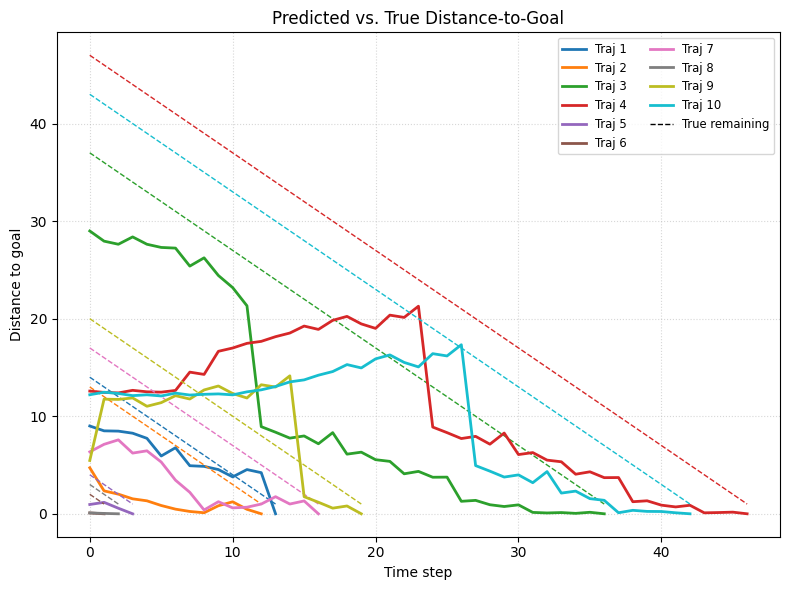

In [ ]:
#Compute the average Spearman correlation
avg_corr = get_correlation(test_trajectories, test_lengths, estimator_contrast)
print(f"Avg. Spearman correlation over test trajs: {avg_corr:.3f}")

# Plot predicted vs. true distance‐to‐goal curves
plot_distances(test_trajectories, test_lengths, estimator_contrast)

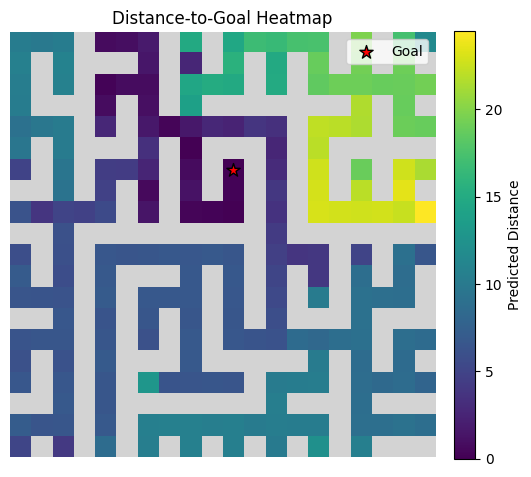

In [ ]:
plot_maze_heatmap(raw_board, estimator_contrast)

In [ ]:
check_solved_rate(estimator_contrast, n_instances, do_search=True)

Solved rate: 1.0
Average expanded: 44.7025


In [ ]:
check_solved_rate(estimator_contrast, n_instances, do_search=False)

Solved rate: 0.1475
Average expanded: 9.4275


### Supervised Model

In [ ]:
model_super = BroNet(800, 400).to(device)
trainer_super = SupervisedTrainer(
    model=model_super,
    train_steps=train_steps,
    batch_size=batch_size,
    lr=learning_rate,
    traj_path=traj_path,
    len_path=len_path,
    n_train_trajectories=n_train_trajectories,
    checkpoint_frequency=checkpoint_freq,
    output_dir=os.path.join(output_dir, 'supervised')
)
estimator_super = ValueEstimatorSupervised(model_super)

In [ ]:
print("Training Supervised Model...")
trainer_super.train_model()

Training Supervised Model...


Training: 100%|██████████| 20000/20000 [16:58<00:00, 19.64step/s, loss=0.3148]


In [ ]:
os.makedirs(trainer_super.output_dir, exist_ok=True)
torch.save(model_super.state_dict(), os.path.join(trainer_super.output_dir, 'final_supervised_15k.pth'))
print("Supervised training complete.")

Supervised training complete.


In [ ]:
ckpt_path = os.path.join(trainer_super.output_dir, 'final_supervised_20k.pth')
state = torch.load(ckpt_path, map_location=device)
model_super.load_state_dict(state)
model_super.eval()

BroNet(
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b4_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b4_ln1): Laye

Avg. Spearman correlation over test trajs: 0.848


/tmp/ipython-input-8-68976691.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_state = torch.tensor(state_str)
/tmp/ipython-input-12-2503962224.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = spearmanr(distances.cpu(), np.arange(len(distances.cpu()))).statistic


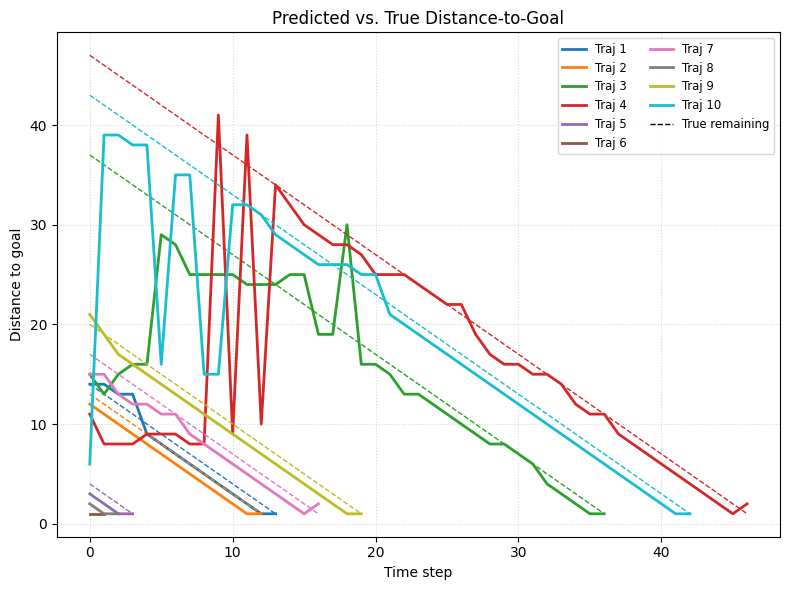

In [ ]:
#Compute the average Spearman correlation
avg_corr = get_correlation(test_trajectories, test_lengths, estimator_super)
print(f"Avg. Spearman correlation over test trajs: {avg_corr:.3f}")

# Plot predicted vs. true distance‐to‐goal curves
plot_distances(test_trajectories, test_lengths, estimator_super)

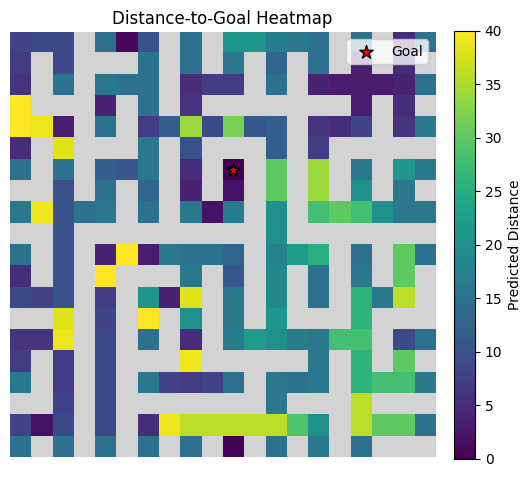

In [ ]:
plot_maze_heatmap(raw_board, estimator_super)

In [ ]:
check_solved_rate(estimator_super, n_instances, do_search=True)

Solved rate: 1.0
Average expanded: 46.735


In [ ]:
check_solved_rate(estimator_super, n_instances, do_search=False)

Solved rate: 0.3025
Average expanded: 10.9275


## Stitching dataset

In [ ]:
# Heatmap
dataset = SupervisedDataset(traj_path, len_path, 4000, 0.9)
test_trajectories, test_lengths = dataset._get_trajs(10, split='test')

traj = joblib.load(traj_path)
raw_board = traj[0][0].copy()
raw_board[raw_board > 1] = 0

free_cells = np.argwhere(raw_board == 0)
goal_i, goal_j = free_cells[np.random.choice(len(free_cells))]
raw_board[goal_i, goal_j] = 3

### Contrastive Model

In [ ]:
train_steps = 15000
batch_size = 64
learning_rate = 1e-3
gamma = 0.90
checkpoint_freq = 1000
n_train_trajectories = 4000

# Evaluation settings
n_instances = 400
n_eval_trajectories = 5

In [ ]:
# Initialize contrastive model and trainer
stitch_model_contrast = BroNet().to(device)
stitch_trainer_contrast = ContrastiveTrainer(
    model=stitch_model_contrast,
    train_steps=train_steps,
    batch_size=batch_size,
    lr=learning_rate,
    traj_path=stitch_traj_path,
    len_path=stitch_len_path,
    n_train_trajectories=n_train_trajectories,
    checkpoint_frequency=checkpoint_freq,
    output_dir=os.path.join(output_dir, 'contrastive')
)
stitch_estimator_contrast = ValueEstimatorContrastive(stitch_model_contrast)

In [ ]:
print("Training Contrastive Model...")
stitch_trainer_contrast.train_model()

Training Contrastive Model...


Training: 100%|██████████| 15000/15000 [11:35<00:00, 21.58step/s, loss=373.6777]


In [ ]:
os.makedirs(stitch_trainer_contrast.output_dir, exist_ok=True)
torch.save(stitch_model_contrast.state_dict(), os.path.join(stitch_trainer_contrast.output_dir, 'stitch_final_contrastive_15k_gamma_90.pth'))
print("Contrastive training complete.")

Contrastive training complete.


In [ ]:
ckpt_path = os.path.join(stitch_trainer_contrast.output_dir, 'stitch_final_contrastive_20k_gamma_90.pth')
state = torch.load(ckpt_path, map_location=device) #torch.device('cpu')
stitch_model_contrast.load_state_dict(state)
stitch_model_contrast.eval()

BroNet(
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b4_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b4_ln1): Laye

Avg. Spearman correlation over test trajs: 0.939


/tmp/ipython-input-8-68976691.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_state = torch.tensor(state_str)


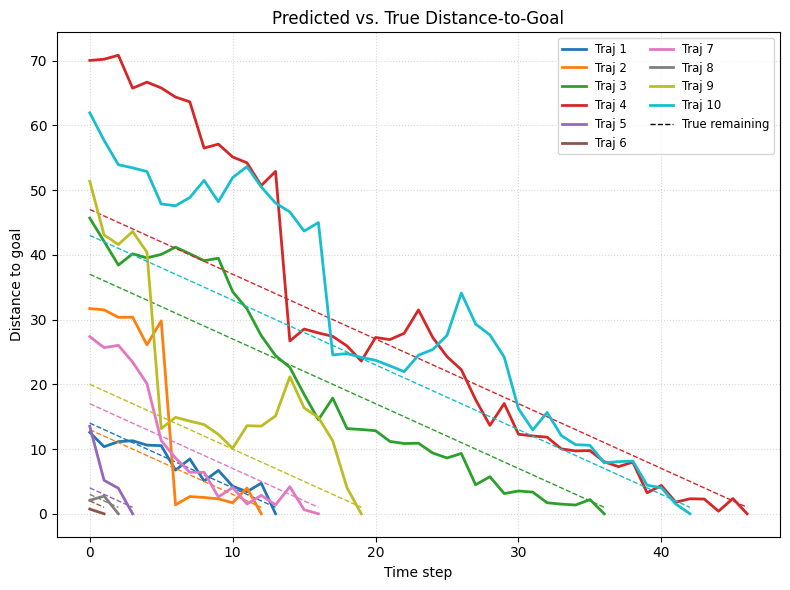

In [ ]:
#Compute the average Spearman correlation
avg_corr = get_correlation(test_trajectories, test_lengths, stitch_estimator_contrast)
print(f"Avg. Spearman correlation over test trajs: {avg_corr:.3f}")

# Plot predicted vs. true distance‐to‐goal curves
plot_distances(test_trajectories, test_lengths, stitch_estimator_contrast)

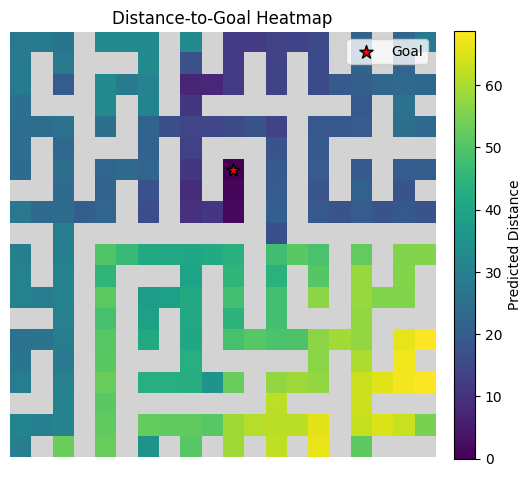

In [ ]:
plot_maze_heatmap(raw_board, stitch_estimator_contrast)

In [ ]:
check_solved_rate(stitch_estimator_contrast, n_instances, do_search=True)

Solved rate: 1.0
Average expanded: 43.5275


In [ ]:
check_solved_rate(stitch_estimator_contrast, n_instances, do_search=False)

Solved rate: 0.18
Average expanded: 11.485


### Supervised Model

In [ ]:
train_steps = 15000
batch_size = 64
learning_rate = 1e-3
gamma = 0.90
checkpoint_freq = 1000
n_train_trajectories = 4000

# Evaluation settings
n_instances = 400
n_eval_trajectories = 5

In [ ]:
stitch_model_super = BroNet(800, 400).to(device)
stitch_trainer_super = SupervisedTrainer(
    model=stitch_model_super,
    train_steps=train_steps,
    batch_size=batch_size,
    lr=learning_rate,
    traj_path=stitch_traj_path,
    len_path=stitch_len_path,
    n_train_trajectories=n_train_trajectories,
    checkpoint_frequency=checkpoint_freq,
    output_dir=os.path.join(output_dir, 'supervised')
)
stitch_estimator_super = ValueEstimatorSupervised(stitch_model_super)

In [ ]:
print("Training Supervised Model...")
stitch_trainer_super.train_model()

Training Supervised Model...


Training: 100%|██████████| 15000/15000 [10:59<00:00, 22.74step/s, loss=0.1092]


In [ ]:
os.makedirs(stitch_trainer_super.output_dir, exist_ok=True)
torch.save(stitch_model_super.state_dict(), os.path.join(stitch_trainer_super.output_dir, 'stitch_final_supervised_15k.pth'))
print("Supervised training complete.")

Supervised training complete.


In [ ]:
ckpt_path = os.path.join(trainer_super.output_dir, 'stitch_final_supervised_20k.pth')
state = torch.load(ckpt_path, map_location=device)
stitch_model_super.load_state_dict(state)
stitch_model_super.eval()

BroNet(
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b1_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b1_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b2_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b2_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b3_fc2): Linear(in_features=128, out_features=128, bias=True)
  (b3_ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (b4_fc1): Linear(in_features=128, out_features=128, bias=True)
  (b4_ln1): Laye

Avg. Spearman correlation over test trajs: 0.470


/tmp/ipython-input-8-68976691.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_state = torch.tensor(state_str)


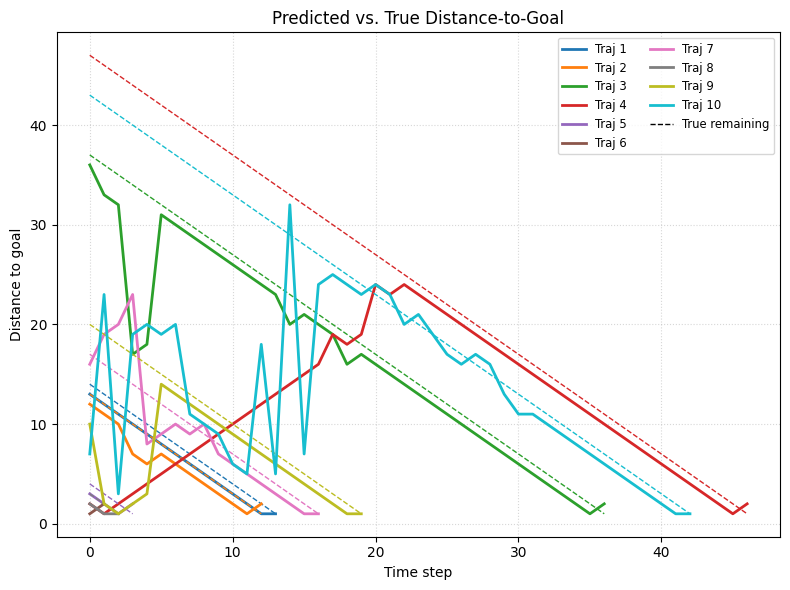

In [ ]:
#Compute the average Spearman correlation
avg_corr = get_correlation(test_trajectories, test_lengths, stitch_estimator_super)
print(f"Avg. Spearman correlation over test trajs: {avg_corr:.3f}")

# Plot predicted vs. true distance‐to‐goal curves
plot_distances(test_trajectories, test_lengths, stitch_estimator_super)

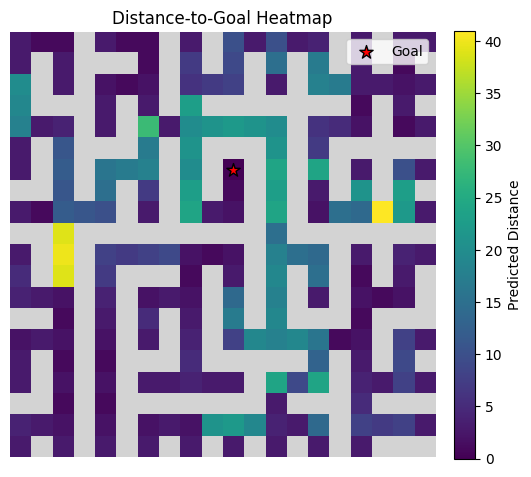

In [ ]:
plot_maze_heatmap(raw_board, stitch_estimator_super)

In [ ]:
check_solved_rate(stitch_estimator_super, n_instances, do_search=True)

Solved rate: 1.0
Average expanded: 66.56


In [ ]:
check_solved_rate(stitch_estimator_super, n_instances, do_search=False)

Solved rate: 0.14
Average expanded: 9.2775
